# **LSTM Prediction model**
This notebook will be dividided by sections as follows:\
-Data load\
-Data Preparation\
-Build LSTM\
-Fit LSTM\
-Forecast Predictions\

### **Data Loading**

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime as dt
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import random


confirmed_cases = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
confirmed_deaths = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
confirmed_recovered = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

In [2]:
confirmed_cases

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,6/13/20,6/14/20,6/15/20,6/16/20,6/17/20,6/18/20,6/19/20,6/20/20,6/21/20,6/22/20
0,NaN,Afghanistan,33.000000,65.000000,0,0,0,0,0,0,...,24102,24766,25527,26310,26874,27532,27878,28424,28833,29157
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,...,1464,1521,1590,1672,1722,1788,1838,1891,1962,1995
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,...,10810,10919,11031,11147,11268,11385,11504,11631,11771,11920
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,...,853,853,853,854,854,855,855,855,855,855
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,...,138,140,142,148,155,166,172,176,183,186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,NaN,Sao Tome and Principe,0.186360,6.613081,0,0,0,0,0,0,...,659,661,662,671,683,688,693,698,698,702
262,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,...,705,728,844,885,902,909,919,922,941,967
263,NaN,Comoros,-11.645500,43.333300,0,0,0,0,0,0,...,176,176,176,197,197,210,210,247,247,247
264,NaN,Tajikistan,38.861034,71.276093,0,0,0,0,0,0,...,4971,5035,5097,5160,5221,5279,5338,5399,5457,5513


In [3]:
class DataNew():
    def __init__(self,country):
        self.country = country
        self.confirmed = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
        self.deaths = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
        self.recovered = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
        self.PreparaData()

    def PreparaData(self):
        timesteps = []
        total_infetados = []
        total_Days = []
        total_Deaths = []
        total_Recovered = []
        self.new_dataset = pd.DataFrame()
        Ground_Zero = dt.strptime('12/31/19','%m/%d/%y')
        for cols in self.confirmed.columns:
            timesteps.append(cols)
            total_infetados.append(self.confirmed[cols].sum())
            current_date = dt.strptime(cols,'%m/%d/%y')
            days_Gone = current_date - Ground_Zero
            total_Days.append(int(days_Gone.days))
        for cols in self.deaths.columns:
            total_Deaths.append(self.deaths[cols].sum())
        for cols in self.recovered.columns:
            total_Recovered.append(self.recovered[cols].sum())
        self.new_dataset['Total_Cases'] = total_infetados
        self.new_dataset['Total_Recovered'] = total_Recovered
        self.new_dataset['Total_Deaths'] = total_Deaths
        self.new_dataset['Days_Gone'] = total_Days
        pd.DataFrame.to_csv(self.new_dataset,'Dados/new_dataset.csv',index=False)
        

### **Data Preparation**
To prepare the data to feed the LSTM network, eah row is correspondant to a day and each collumn is a total for a specific country as follows:\
-Total_Cases\
-Total_Deaths\
-Total_Recoveries\
-Days_Gone

In [4]:
class Data():
    def __init__(self,country):
        self.country = country
        self.confirmed = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
        self.deaths = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
        self.recovered = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
        if(country == "World Wide"):
            self.PreparaDataGlobal()
        else:
            self.PreparaData()

    def PreparaData(self):
        confirmedPortugal = self.confirmed[ self.confirmed['Country/Region'] != self.country].index
        self.confirmed.drop(confirmedPortugal , inplace=True)
        deathsPortugal = self.deaths[ self.deaths['Country/Region'] != self.country].index
        self.deaths.drop(deathsPortugal , inplace=True)
        recoveredPortugal = self.recovered[ self.recovered['Country/Region'] != self.country].index
        self.recovered.drop(recoveredPortugal , inplace=True)
        self.confirmed = self.confirmed.drop(columns=['Province/State','Country/Region','Lat','Long'])
        self.deaths = self.deaths.drop(columns=['Province/State','Country/Region','Lat','Long'])
        self.recovered = self.recovered.drop(columns=['Province/State','Country/Region','Lat','Long'])
        timesteps = []
        total_infetados = []
        total_Days = []
        total_Deaths = []
        total_Recovered = []
        daily_deaths=[]
        daily_cases=[]
        day_of_week=[]
        self.new_dataset = pd.DataFrame()
        Ground_Zero = dt.strptime('12/31/19','%m/%d/%y')
        for cols in self.confirmed.columns:
            timesteps.append(cols)
            total_infetados.append(self.confirmed[cols].sum())
            current_date = dt.strptime(cols,'%m/%d/%y')
            day_of_week.append(current_date.weekday())
            days_Gone = current_date - Ground_Zero
            total_Days.append(int(days_Gone.days))
            daily_cases.append(self.confirmed[cols].sum()-sum(daily_cases))
        for cols in self.deaths.columns:
            total_Deaths.append(self.deaths[cols].sum())
            daily_deaths.append(self.deaths[cols].sum()-sum(daily_deaths))
        for cols in self.recovered.columns:
            total_Recovered.append(self.recovered[cols].sum())
        self.new_dataset['Total_Cases'] = total_infetados
        self.new_dataset['WeekDay'] = day_of_week
        self.new_dataset['Daily_Cases'] = daily_cases
        self.new_dataset['Daily_Deaths'] = daily_deaths
        self.new_dataset['Total_Recovered'] = total_Recovered
        self.new_dataset['Total_Deaths'] = total_Deaths
        self.new_dataset['Days_Gone'] = total_Days
        pd.DataFrame.to_csv(self.new_dataset,'Dados/new_dataset.csv',index=False)
    def PreparaDataGlobal(self):
        self.confirmed = self.confirmed.drop(columns=['Province/State','Country/Region','Lat','Long'])
        self.deaths = self.deaths.drop(columns=['Province/State','Country/Region','Lat','Long'])
        self.recovered = self.recovered.drop(columns=['Province/State','Country/Region','Lat','Long'])
        timesteps = []
        total_infetados = []
        total_Days = []
        total_Deaths = []
        total_Recovered = []
        self.new_dataset = pd.DataFrame()
        Ground_Zero = dt.strptime('12/31/19','%m/%d/%y')
        for cols in self.confirmed.columns:
            timesteps.append(cols)
            total_infetados.append(self.confirmed[cols].sum())
            current_date = dt.strptime(cols,'%m/%d/%y')
            days_Gone = current_date - Ground_Zero
            total_Days.append(int(days_Gone.days))
        for cols in self.deaths.columns:
            total_Deaths.append(self.deaths[cols].sum())
        for cols in self.recovered.columns:
            total_Recovered.append(self.recovered[cols].sum())
        self.new_dataset['Total_Cases'] = total_infetados
        self.new_dataset['Total_Recovered'] = total_Recovered
        self.new_dataset['Total_Deaths'] = total_Deaths
        self.new_dataset['Days_Gone'] = total_Days
        pd.DataFrame.to_csv(self.new_dataset,'Dados/new_dataset.csv',index=False)



### **Feeding LSTM**
To feed the LSTM, we give 15 timesteps wich correspond to 15 individual days.\
The model uses a single column,Total_Cases, to predict the total cases for each country.\
The Model receives all data normalized in range [-1,1], this maximizes perfomance

In [5]:
class LSTM():
    def __init__(self):
        self.df = pd.read_csv('Dados/new_dataset.csv')
        self.NormalizeData()
        self.timesteps = 15
        self.nr_parametos=2
        self.PrepareData(self.timesteps)
        self.Build(self.timesteps,self.nr_parametos)
        self.Fit()
    def NormalizeData(self):
        self.scaler = MinMaxScaler(feature_range=(-1, 1))
        self.normalized = self.scaler.fit_transform(self.df)
        #print(self.normalized)
        
    def Denormalize(self,dfNormalized):
        pass
    
    
    def PrepareData(self,timesteps):
        i = 0
        self.X = []
        self.Y = []
        while i in range(len(self.normalized - timesteps)):
            input_index = i + timesteps
            label_index = input_index + 1
            if(label_index < len(self.normalized)):
                self.X.append(self.normalized[i:input_index,1:3])
                self.Y.append(self.normalized[input_index:label_index,2])
            i+=1
        self.X = np.array(self.X)
        self.Y = np.array(self.Y)
        self.X_test = self.X[-10:]
        self.Y_test = self.Y[-10:]
        self.X = self.X[:-10]
        self.Y = self.Y[:-10]
        #print(self.X)
        X = self.X
        #print(self.Y)
        Y=self.Y
    
    '''
    def Prepare_Data(self,dataset):
        x = dataset.drop(columns=['Total_Deaths'])
        self.X = x.to_numpy()
        y = dataset['Total_Deaths']
        self.Y = y.to_numpy()
        self.Y = self.Y.astype(float)
    '''
    def Build(self,janela,nmr_parametros):
        self.model = keras.Sequential()
        self.model.add(keras.layers.LSTM(32, input_shape=(janela, nmr_parametros), return_sequences=True))
        self.model.add(keras.layers.LSTM(64, return_sequences=True))
        self.model.add(keras.layers.LSTM(128, return_sequences=False))
        self.model.add(keras.layers.Dropout(0.2))
        self.model.add(keras.layers.Dense(32, activation="relu", kernel_initializer="uniform"))
        self.model.add(keras.layers.Dropout(0.2))
        self.model.add(keras.layers.Dense(1, activation="linear"))
    
    def BuildDeaths(self,janela,nmr_parametros):
        self.modelDeaths = keras.Sequential()
        self.modelDeaths.add(keras.layers.LSTM(32, input_shape=(janela, nmr_parametros), return_sequences=True))
        self.modelDeaths.add(keras.layers.LSTM(64, return_sequences=True))
        self.modelDeaths.add(keras.layers.LSTM(128, return_sequences=False))
        self.modelDeaths.add(keras.layers.Dropout(0.2))
        self.modelDeaths.add(keras.layers.Dense(32, activation="relu", kernel_initializer="uniform"))
        self.modelDeaths.add(keras.layers.Dropout(0.2))
        self.modelDeaths.add(keras.layers.Dense(1, activation="linear"))
        
    def RMSE(self,y_true,y_pred):
        return keras.backend.sqrt(keras.backend.mean(keras.backend.square(y_pred - y_true)))

    def Fit(self):
        self.model.compile(loss=self.RMSE,optimizer=keras.optimizers.Adam(),metrics=['mae',self.RMSE])
        try:
            self.model.load_weights("model.h5")
        except:
            print('Model not found')
        self.history = self.model.fit(x=self.X,y=self.Y,epochs=150,batch_size = 7,validation_split=0.05,shuffle=False,verbose=False)
        self.model.save_weights("model.h5")
    def PredictTest(self,data):
        result = self.model.predict(data,verbose=False)
        results = []
        for res in result:
            Denormalized = np.ndarray((1,7))
            Denormalized[0][0] = -1
            Denormalized[0][1] = -1
            Denormalized[0][2] = res
            Denormalized[0][3] = -1
            Denormalized[0][4] = -1
            Denormalized[0][5] = -1
            Denormalized[0][6] = -1
            #print(self.scaler)
            #print(self.normalized)
            value = self.scaler.inverse_transform(Denormalized)
            #print(value)
            results.append(value[0][2])
        return results
    
    def Predict(self,data):
        result = self.model.predict(data,verbose=False)
        return result
        
    def forecast(self):
        timesteps= self.timesteps
        multisteps=50
        data_norm=pd.DataFrame(self.normalized)
        input_seq=data_norm[-timesteps:].values
        inp=input_seq[:,1:3]
        
        
        predictions=list()
        
        inp = np.array(inp).astype('float32')
        #print(inp)
        for step in range(1, multisteps+1):
            
            inp=inp.reshape(1,timesteps,2)
            
            taxa_Erro = random.uniform(-0.005,0.005 )

            yhat=self.Predict(inp) + taxa_Erro
            
            Denormalized = np.ndarray((1,7))
            Denormalized[0][0] = -1
            Denormalized[0][1] = inp[0][inp.shape[1]-1][1]
            Denormalized[0][2] = yhat
            Denormalized[0][3] = -1
            Denormalized[0][4] = -1
            Denormalized[0][5] = -1
            Denormalized[0][6] = -1
            #print(self.scaler)
            #print(self.normalized)
            value = self.scaler.inverse_transform(Denormalized)
            #print(value)
            predictions.append(value[0][2])
            #predictions.append(yhat[0][0])
            newCase = np.array((float(yhat),inp[0][inp.shape[1]-7][1]))  #
            inp = np.append(inp, newCase)
            inp = np.reshape(inp,(-1,2))
            inp=inp[-timesteps:,:]
            #print(inp)
        self.PredictionGraph(predictions)
    def PredictionGraph(self,prediction):
        new_pred = []
        verificador = 0
        for pred in prediction:
            if(verificador == 0):  
                new_pred.append(self.df['Total_Cases'].iloc[-1] + int(pred))
                verificador = 1
            else:
                new_pred.append(new_pred[-1] + int(pred))
        fig, ax = plt.subplots(figsize=(20, 10))
        fig.suptitle('Previsao Casos ', fontweight='bold',fontsize=30, color='#0c3c6e')
        plt.xlabel('Dia', fontsize=20)
        plt.ylabel('Previsão', fontsize=20)
        ax.plot(np.arange(len(self.df)),(self.df['Total_Cases']), label='Days Gone with real data')
        ax.plot(np.arange(len(self.df),len(self.df) + len(new_pred)),(new_pred), label='50 days LSTM prediction')
        ax.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1,fontsize='15')
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
              
        ax.grid()
        #fig.savefig('static/lstm.png')
        
        
        #-------------------------------------------------Second Graph---------------------------------------------------
        
        fig, ax = plt.subplots(figsize=(20, 10))
        fig.suptitle('Daily Corona Cases ', fontsize=15, color='#0c3c6e')

        plt.xlabel('Day', fontsize=10)
        plt.ylabel('Cases per day', fontsize=10)
        
        DenormalizedData = pd.read_csv('Dados/new_dataset.csv')
        
        DenormalizedData=DenormalizedData[DenormalizedData['Total_Cases']>0]
        
        df_values = pd.DataFrame()
        df_values['CasosDiarios']=DenormalizedData['Daily_Cases']
        
        df_values = df_values.reset_index()
        df_values = df_values.drop(['index'],axis=1)

        ax.bar(df_values.index,df_values[:]['CasosDiarios'],label='Real')
        last_index = df_values.index[-1] + 1
        index = []
        for i in range(len(prediction)):
            index.append(i+last_index)
        ax.bar(index,prediction,label='Previsão')
        ax.grid()
        #fig.savefig('static/Casos_diarios.png')
        ax.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1,fontsize='15')
        plt.show()

    def barplot(self,predictions):
        teste = []
        for res in self.Y_test.flatten():
            Denormalized = np.ndarray((1,7))
            Denormalized[0][0] = -1
            Denormalized[0][1] = -1
            Denormalized[0][2] = res
            Denormalized[0][3] = -1
            Denormalized[0][4] = -1
            Denormalized[0][5] = -1
            Denormalized[0][6] = -1
            #print(self.scaler)
            #print(self.normalized)
            value = self.scaler.inverse_transform(Denormalized)
            #print(value)
            teste.append(value[0][2])
        
        df = pd.DataFrame({'Actual': teste, 'Predicted': np.asarray(predictions).flatten()})

        df1 = df.head(25)
        df1.plot(kind='bar',figsize=(16,10))
        plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
        plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
        plt.show()
        
    def PlotLoss(self):
        fig, ax = plt.subplots(figsize=(20, 10))
        print(self.model.history.history.keys())
        plt.plot(self.model.history.history['loss'])
        plt.plot(self.model.history.history['val_loss'])
        plt.title('loss vs val_loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['loss'], loc='upper left')
        plt.show()

In [19]:
class LSTMDeaths():
    def __init__(self):
        self.df = pd.read_csv('Dados/new_dataset.csv')
        self.NormalizeData()
        self.timesteps = 15
        self.nr_parametos=3
        self.PrepareData(self.timesteps)
        self.Build(self.timesteps,self.nr_parametos)
        self.Fit()
    def NormalizeData(self):
        self.scaler = MinMaxScaler(feature_range=(-1, 1))
        self.normalized = self.scaler.fit_transform(self.df)
        #print(self.normalized)
        
    def PrepareData(self,timesteps):
        i = 0
        self.X = []
        self.Y = []
        while i in range(len(self.normalized - timesteps)):
            input_index = i + timesteps
            label_index = input_index + 1
            if(label_index < len(self.normalized)):
                self.X.append(self.normalized[i:input_index,1:4])
                self.Y.append(self.normalized[input_index:label_index,3])
            i+=1
        self.X = np.array(self.X)
        self.Y = np.array(self.Y)
        self.X_test = self.X[-10:]
        self.Y_test = self.Y[-10:]
        self.X = self.X[:-10]
        self.Y = self.Y[:-10]
        #print(self.X)
        X = self.X
        #print(self.Y)
        Y=self.Y
    
    '''
    def Prepare_Data(self,dataset):
        x = dataset.drop(columns=['Total_Deaths'])
        self.X = x.to_numpy()
        y = dataset['Total_Deaths']
        self.Y = y.to_numpy()
        self.Y = self.Y.astype(float)
    '''
    def Build(self,janela,nmr_parametros):
        self.model = keras.Sequential()
        self.model.add(keras.layers.LSTM(32, input_shape=(janela, nmr_parametros), return_sequences=True))
        self.model.add(keras.layers.LSTM(64, return_sequences=True))
        self.model.add(keras.layers.LSTM(128, return_sequences=False))
        self.model.add(keras.layers.Dropout(0.2))
        self.model.add(keras.layers.Dense(32, activation="relu", kernel_initializer="uniform"))
        self.model.add(keras.layers.Dropout(0.2))
        self.model.add(keras.layers.Dense(1, activation="linear"))
    
    def BuildDeaths(self,janela,nmr_parametros):
        self.modelDeaths = keras.Sequential()
        self.modelDeaths.add(keras.layers.LSTM(32, input_shape=(janela, nmr_parametros), return_sequences=True))
        self.modelDeaths.add(keras.layers.LSTM(64, return_sequences=True))
        self.modelDeaths.add(keras.layers.LSTM(128, return_sequences=False))
        self.modelDeaths.add(keras.layers.Dropout(0.2))
        self.modelDeaths.add(keras.layers.Dense(32, activation="relu", kernel_initializer="uniform"))
        self.modelDeaths.add(keras.layers.Dropout(0.2))
        self.modelDeaths.add(keras.layers.Dense(1, activation="linear"))
        
    def RMSE(self,y_true,y_pred):
        return keras.backend.sqrt(keras.backend.mean(keras.backend.square(y_pred - y_true)))

    def Fit(self):
        self.model.compile(loss=self.RMSE,optimizer=keras.optimizers.Adam(),metrics=['mae',self.RMSE])
        try:
            self.model.load_weights("modelDeaths.h5")
        except:
            print('Model not found')
        self.history = self.model.fit(x=self.X,y=self.Y,epochs=150,batch_size = 4,validation_split=0.05,shuffle=False)
        self.model.save_weights("modelDeaths.h5")
    def PredictTest(self,data):
        result = self.model.predict(data,verbose=True)
        print(result)
        results = []
        for res in result:
            Denormalized = np.ndarray((1,7))
            Denormalized[0][0] = -1
            Denormalized[0][1] = -1
            Denormalized[0][2] = -1
            Denormalized[0][3] = res
            Denormalized[0][4] = -1
            Denormalized[0][5] = -1
            Denormalized[0][6] = -1
            #print(self.scaler)
            #print(self.normalized)
            value = self.scaler.inverse_transform(Denormalized)
            #print(value)
            results.append(value[0][3])
        return results
    
    def Predict(self,data):
        result = self.model.predict(data,verbose=True)
        return result
        
    def forecast(self):
        timesteps= self.timesteps
        multisteps=50
        data_norm=pd.DataFrame(self.normalized)
        input_seq=data_norm[-timesteps:].values
        inp=input_seq[:,1:3]
        
        
        predictions=list()
        
        inp = np.array(inp).astype('float32')
        #print(inp)
        for step in range(1, multisteps+1):
            
            inp=inp.reshape(1,timesteps,2)
            
            taxa_Erro = random.uniform(-0.005,0.005 )

            yhat=self.Predict(inp) + taxa_Erro
            
            Denormalized = np.ndarray((1,7))
            Denormalized[0][0] = -1
            Denormalized[0][1] = -1
            Denormalized[0][2] = inp[0][inp.shape[1]-1][1]
            Denormalized[0][3] = yhat
            Denormalized[0][4] = -1
            Denormalized[0][5] = -1
            Denormalized[0][6] = -1
            #print(self.scaler)
            #print(self.normalized)
            value = self.scaler.inverse_transform(Denormalized)
            #print(value)
            predictions.append(value[0][2])
            #predictions.append(yhat[0][0])
            newCase = np.array((float(yhat),inp[0][inp.shape[1]-7][1]))  #
            inp = np.append(inp, newCase)
            inp = np.reshape(inp,(-1,2))
            inp=inp[-timesteps:,:]
            #print(inp)
        self.PredictionGraph(predictions)
    def PredictionGraph(self,prediction):
        new_pred = []
        verificador = 0
        for pred in prediction:
            if(verificador == 0):  
                new_pred.append(self.df['Total_Cases'].iloc[-1] + int(pred))
                verificador = 1
            else:
                new_pred.append(new_pred[-1] + int(pred))
        fig, ax = plt.subplots(figsize=(20, 10))
        fig.suptitle('Previsao Casos ', fontweight='bold',fontsize=30, color='#0c3c6e')
        plt.xlabel('Dia', fontsize=20)
        plt.ylabel('Previsão', fontsize=20)
        ax.plot(np.arange(len(self.df)),(self.df['Total_Cases']), label='Days Gone with real data')
        ax.plot(np.arange(len(self.df),len(self.df) + len(new_pred)),(new_pred), label='50 days LSTM prediction')
        ax.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1,fontsize='15')
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
              
        ax.grid()
        #fig.savefig('static/lstm.png')

    def barplot(self,predictions):
        teste = []
        for res in self.Y_test.flatten():
            Denormalized = np.ndarray((1,7))
            Denormalized[0][0] = -1
            Denormalized[0][1] = -1
            Denormalized[0][2] = -1
            Denormalized[0][3] = res
            Denormalized[0][4] = -1
            Denormalized[0][5] = -1
            Denormalized[0][6] = -1
            #print(self.scaler)
            #print(self.normalized)
            value = self.scaler.inverse_transform(Denormalized)
            #print(value)
            teste.append(value[0][3])
        
        df = pd.DataFrame({'Actual': teste, 'Predicted': np.asarray(predictions).flatten()})

        df1 = df.head(25)
        df1.plot(kind='bar',figsize=(16,10))
        plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
        plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
        plt.show()
        
    def PlotLoss(self):
        fig, ax = plt.subplots(figsize=(20, 10))
        print(self.model.history.history.keys())
        plt.plot(self.model.history.history['loss'])
        plt.plot(self.model.history.history['val_loss'])
        plt.title('loss vs val_loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['loss'], loc='upper left')
        plt.show()

In [7]:
country = "Portugal"
data = Data(country)


In [8]:
data.new_dataset

,Total_Cases,WeekDay,Daily_Cases,Daily_Deaths,Total_Recovered,Total_Deaths,Days_Gone
0,0,2,0,0,0,0,22
1,0,3,0,0,0,0,23
2,0,4,0,0,0,0,24
3,0,5,0,0,0,0,25
4,0,6,0,0,0,0,26
...,...,...,...,...,...,...,...
148,38089,3,417,1,24010,1524,170
149,38464,4,375,3,24477,1527,171
150,38841,5,377,1,24906,1528,172
151,39133,6,292,2,25376,1530,173


Model not found
dict_keys(['loss', 'mae', 'RMSE', 'val_loss', 'val_mae', 'val_RMSE'])


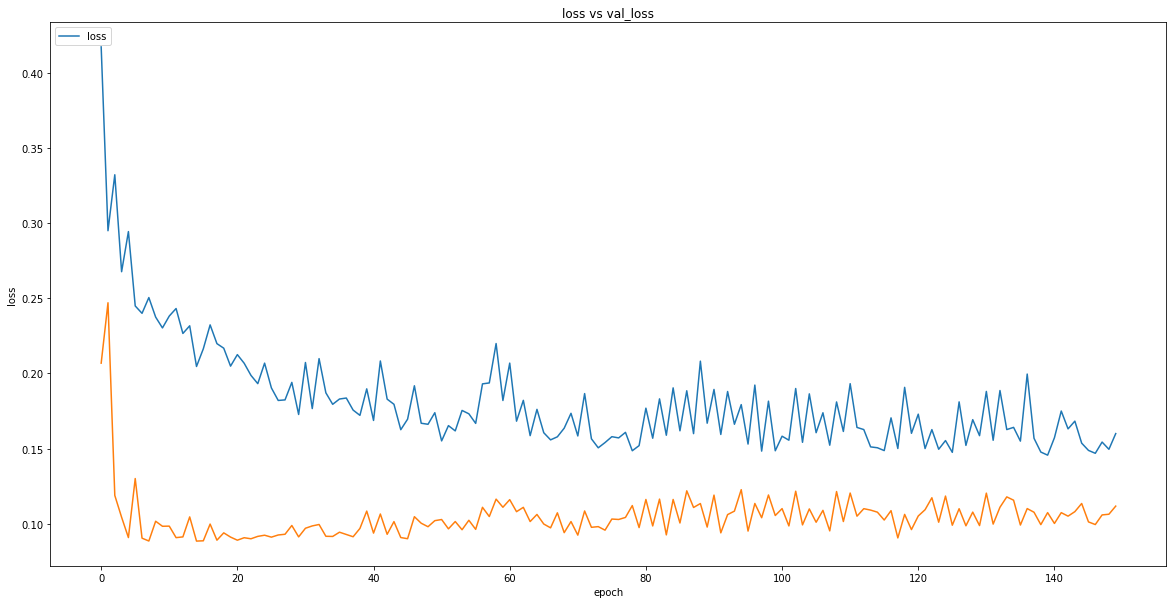

In [9]:
lstm = LSTM()
lstm.PlotLoss()

### **Predictions**
To forecast the future, we feed the last 15 days to predict the next day, then the day predicted gets added to the dataset and the next day is predicted using the last 15 correspondant days.\
After 15 predictions, the network is using its own predictions, this may cause the error to increase but this way we can calculate when the numbers will stagnate in each country.\
The graph shown bellow show the predicted numbers for the US, to predict other countries just change the "country" variable in the cell above.

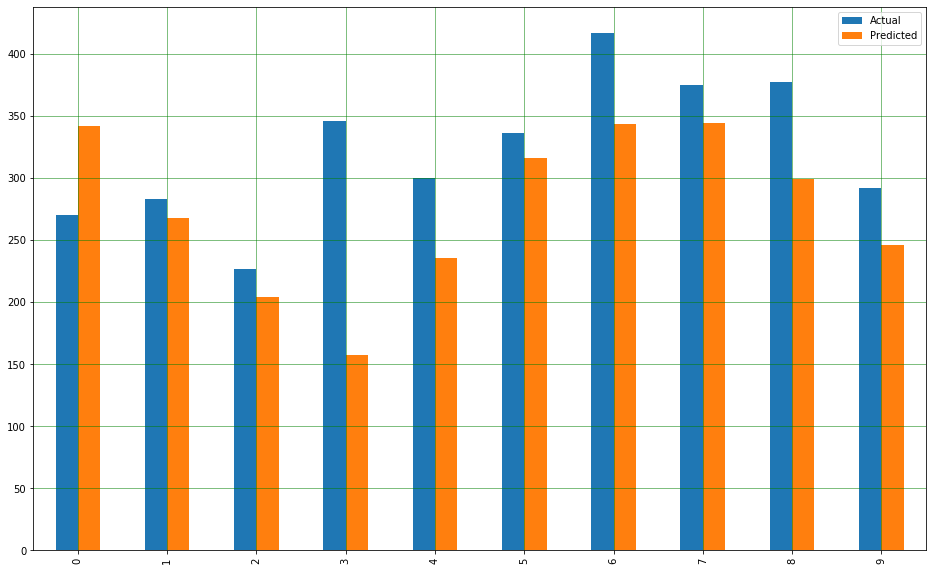

In [10]:
preds = lstm.PredictTest(lstm.X_test)
lstm.barplot(preds)
#lstm.forecast()

In [11]:
results = lstm.model.evaluate(lstm.X_test,lstm.Y_test)

10/10 [==============================] - 1s 118ms/sample - loss: 0.0928 - mae: 0.0729 - RMSE: 0.0928


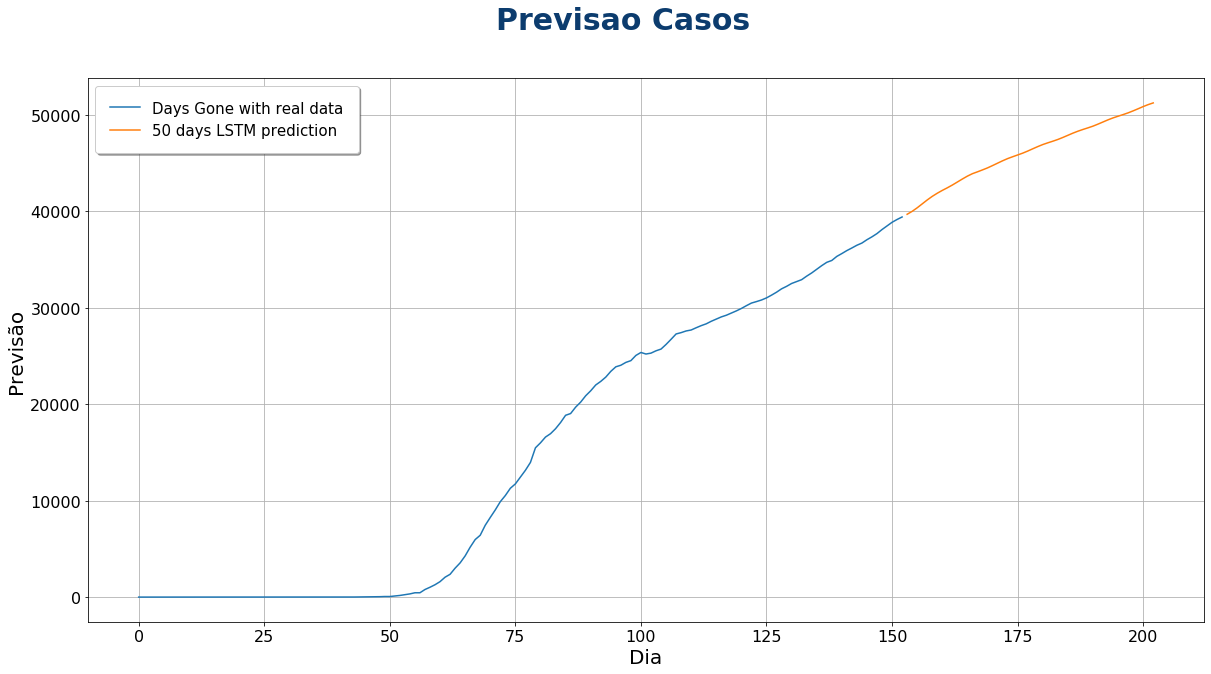

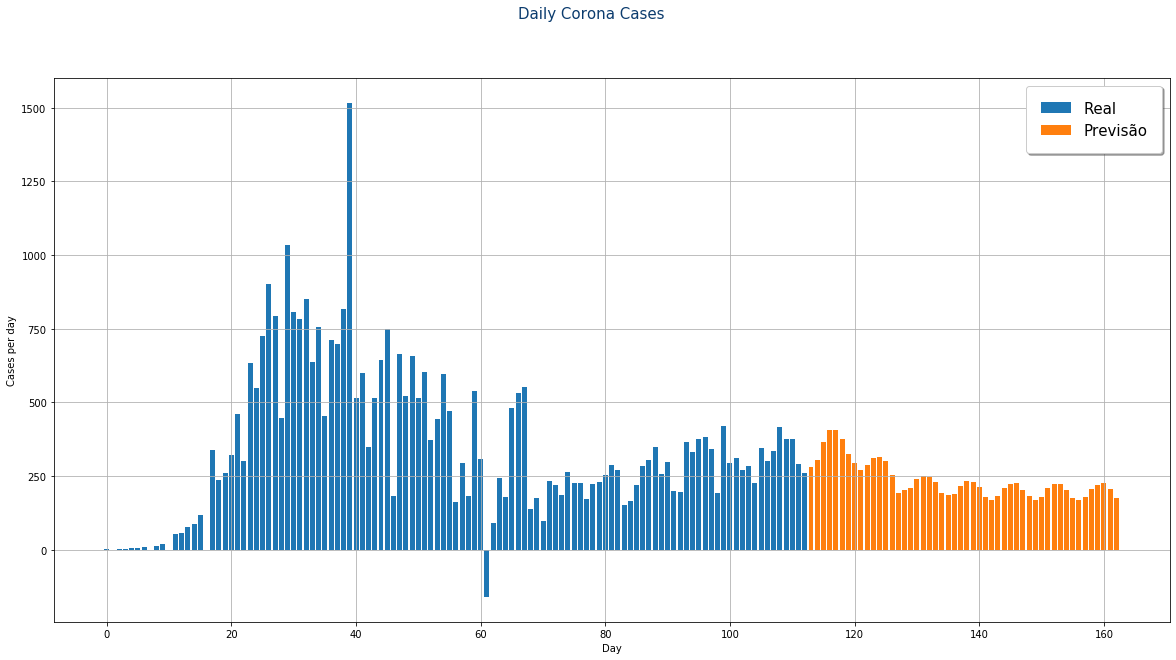

In [12]:
lstm.forecast()

In [20]:
lstmDeaths = LSTMDeaths()

Train on 120 samples, validate on 7 samples
Epoch 1/150
120/120 [==============================] - 6s 47ms/sample - loss: 0.1907 - mae: 0.1642 - RMSE: 0.1907 - val_loss: 0.2828 - val_mae: 0.2662 - val_RMSE: 0.2795
Epoch 2/150
120/120 [==============================] - 0s 3ms/sample - loss: 0.1779 - mae: 0.1518 - RMSE: 0.1779 - val_loss: 0.2824 - val_mae: 0.2642 - val_RMSE: 0.2836
Epoch 3/150
120/120 [==============================] - 0s 3ms/sample - loss: 0.2387 - mae: 0.2051 - RMSE: 0.2387 - val_loss: 0.3684 - val_mae: 0.3556 - val_RMSE: 0.3649
Epoch 4/150
120/120 [==============================] - 0s 3ms/sample - loss: 0.2760 - mae: 0.2472 - RMSE: 0.2760 - val_loss: 0.4111 - val_mae: 0.4002 - val_RMSE: 0.4121
Epoch 5/150
120/120 [==============================] - 0s 3ms/sample - loss: 0.3013 - mae: 0.2740 - RMSE: 0.3013 - val_loss: 0.3527 - val_mae: 0.3450 - val_RMSE: 0.3507
Epoch 6/150
120/120 [==============================] - 0s 3ms/sample - loss: 0.2378 - mae: 0.2093 - RMSE: 0.23

Epoch 49/150
120/120 [==============================] - 0s 3ms/sample - loss: 0.2602 - mae: 0.2263 - RMSE: 0.2602 - val_loss: 0.2780 - val_mae: 0.2610 - val_RMSE: 0.2771
Epoch 50/150
120/120 [==============================] - 0s 3ms/sample - loss: 0.1775 - mae: 0.1529 - RMSE: 0.1775 - val_loss: 0.2254 - val_mae: 0.2024 - val_RMSE: 0.2265
Epoch 51/150
120/120 [==============================] - 0s 3ms/sample - loss: 0.1897 - mae: 0.1639 - RMSE: 0.1897 - val_loss: 0.2664 - val_mae: 0.2479 - val_RMSE: 0.2676
Epoch 52/150
120/120 [==============================] - 0s 3ms/sample - loss: 0.1975 - mae: 0.1725 - RMSE: 0.1975 - val_loss: 0.2090 - val_mae: 0.1893 - val_RMSE: 0.2082
Epoch 53/150
120/120 [==============================] - 0s 3ms/sample - loss: 0.1913 - mae: 0.1644 - RMSE: 0.1913 - val_loss: 0.2524 - val_mae: 0.2325 - val_RMSE: 0.2507
Epoch 54/150
120/120 [==============================] - 0s 3ms/sample - loss: 0.1799 - mae: 0.1562 - RMSE: 0.1799 - val_loss: 0.2573 - val_mae: 0.2383

120/120 [==============================] - 0s 3ms/sample - loss: 0.1744 - mae: 0.1517 - RMSE: 0.1744 - val_loss: 0.2830 - val_mae: 0.2534 - val_RMSE: 0.2825
Epoch 146/150
120/120 [==============================] - 0s 3ms/sample - loss: 0.1947 - mae: 0.1656 - RMSE: 0.1947 - val_loss: 0.2522 - val_mae: 0.2169 - val_RMSE: 0.2548
Epoch 147/150
120/120 [==============================] - 0s 3ms/sample - loss: 0.1826 - mae: 0.1576 - RMSE: 0.1826 - val_loss: 0.2935 - val_mae: 0.2629 - val_RMSE: 0.2944
Epoch 148/150
120/120 [==============================] - 0s 3ms/sample - loss: 0.1636 - mae: 0.1385 - RMSE: 0.1636 - val_loss: 0.3080 - val_mae: 0.2840 - val_RMSE: 0.3097
Epoch 149/150
120/120 [==============================] - 0s 3ms/sample - loss: 0.1562 - mae: 0.1342 - RMSE: 0.1562 - val_loss: 0.2451 - val_mae: 0.2137 - val_RMSE: 0.2440
Epoch 150/150
120/120 [==============================] - 0s 3ms/sample - loss: 0.1674 - mae: 0.1422 - RMSE: 0.1674 - val_loss: 0.2851 - val_mae: 0.2553 - val_R

dict_keys(['loss', 'mae', 'RMSE', 'val_loss', 'val_mae', 'val_RMSE'])


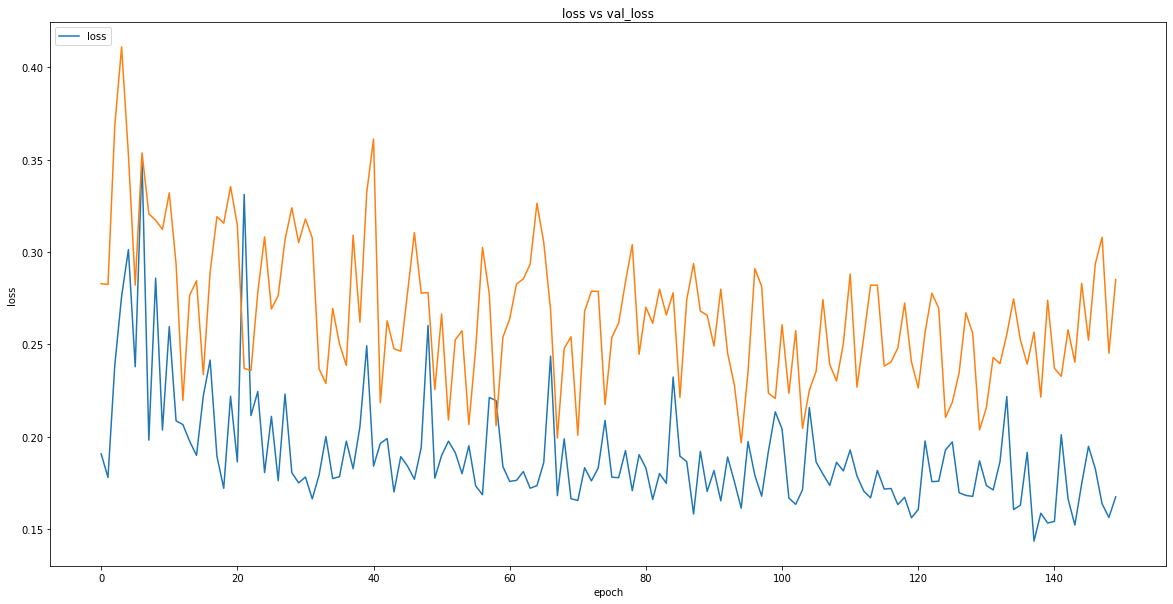

10/10 [==============================] - 1s 129ms/sample
[[-0.46097183]
 [-0.49916285]
 [-0.4072731 ]
 [-0.45506856]
 [-0.39934075]
 [-0.4428109 ]
 [-0.53683364]
 [-0.53658587]
 [-0.494314  ]
 [-0.5074426 ]]


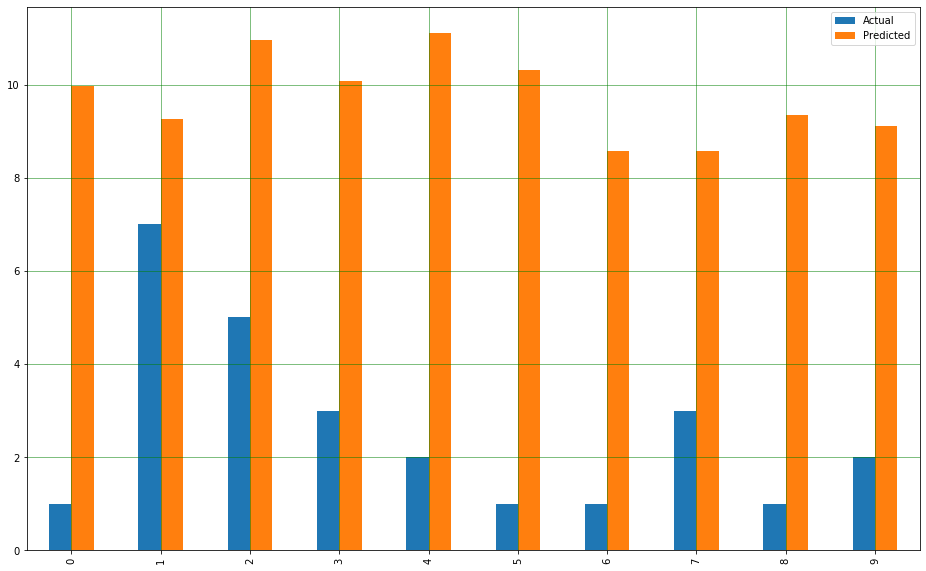

In [21]:
lstmDeaths.PlotLoss()
preds = lstmDeaths.PredictTest(lstmDeaths.X_test)
lstmDeaths.barplot(preds)